# Customer Segmentation

In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import seaborn as sns
import itertools
import missingno as msno 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from pathlib import Path
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
from sklearn.cluster import KMeans

### Loading the data into system and understanding its structure

In [2]:
df = pd.read_csv('/Users/anusha/Desktop/Assignments-Spring2020/AIT-582/Project/data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceNo': str})
print('Dataframe dimensions:', df.shape)
#______

Dataframe dimensions: (541909, 8)


Converting the Invoice Date variable from Date to Datetime

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Display first 5 lines of the data frame

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Data PreProcessing

Display number of missing values grouped by column

In [8]:
data_clean=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
data_clean=data_clean.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
data_clean=data_clean.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Variable type and number of missing values " + '-' * 10 )
print 
display(data_clean)

---------- Variable type and number of missing values ----------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


Visualize missing values : We see that Description and CustomerId has missing values.

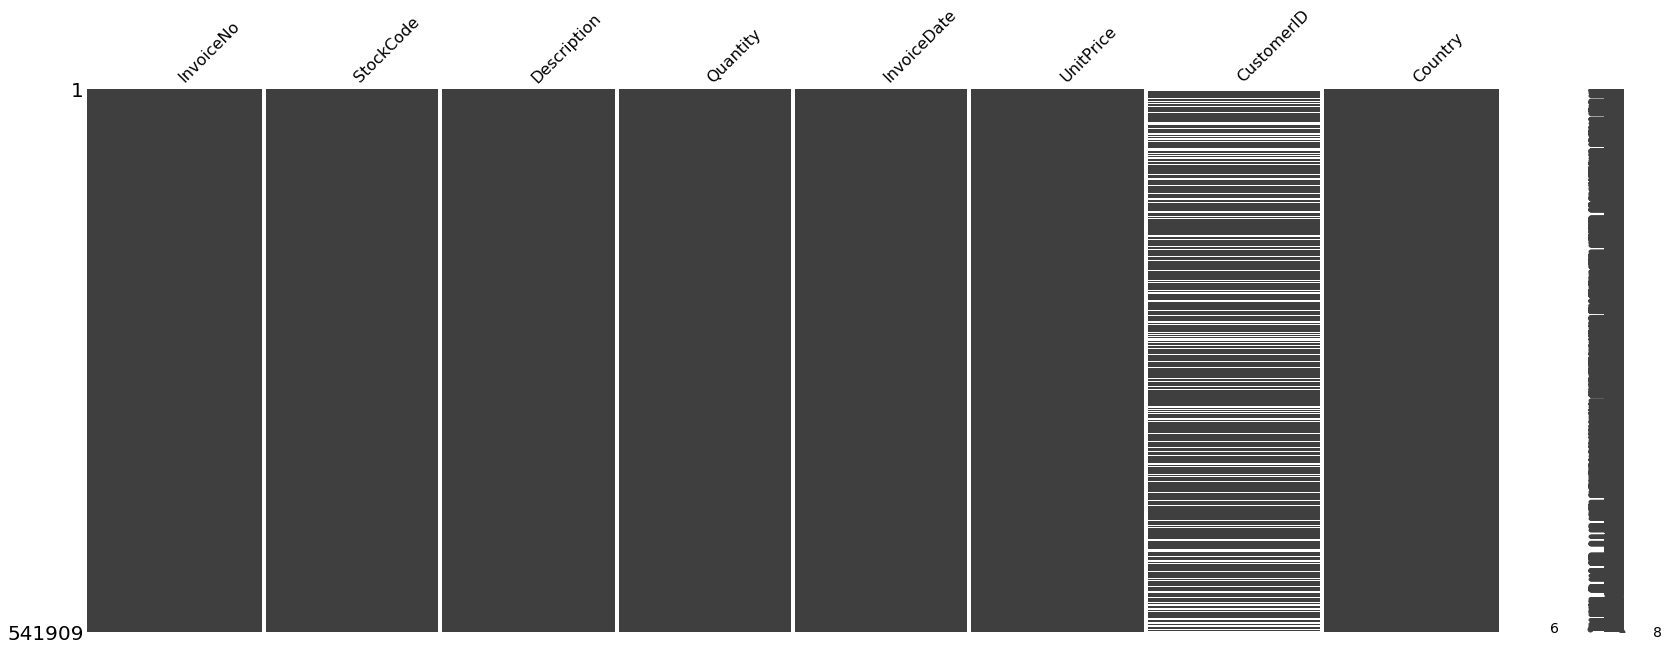

In [9]:
msno.matrix(df) 


Dropping missing values

In [10]:
df.dropna(inplace = True)
print('Dataframe dimensions:',df.shape)
# gives some information on columns types and number of null values
data_clean=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
data_clean=data_clean.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
data_clean=data_clean.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(data_clean)


Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


Dropping duplicate values

In [11]:
print('Duplicate data entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate data entries: 5225


### Exploratory analysis

In [12]:
Customers = df.groupby('CustomerID')['Country'].unique()
Customers.loc[Customers.apply(lambda x:len(x)>1)]

CustomerID
12370           [Cyprus, Austria]
12394          [Belgium, Denmark]
12417            [Belgium, Spain]
12422    [Australia, Switzerland]
12429          [Denmark, Austria]
12431        [Australia, Belgium]
12455             [Cyprus, Spain]
12457       [Switzerland, Cyprus]
Name: Country, dtype: object

Exploring the total number of countries

In [13]:
df_temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
df_temp = df_temp.reset_index(drop = False)
countries = df_temp['Country'].value_counts()
print('No. of countries in dataframe: {}'.format(len(countries)))

No. of countries in dataframe: 37


In [14]:
no_countries = df[['CustomerID','Country']].groupby(['Country']).count()
no_countries = no_countries.reset_index(drop = False)

print('-' * 10 + " Distribution of orders per country "+ '-' * 10)
print
print (no_countries.sort_values(
    by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "No of orders per Country"}))

---------- Distribution of orders per country ----------
                 Country  No of orders per Country
35        United Kingdom                    356728
14               Germany                      9480
13                France                      8475
10                  EIRE                      7475
30                 Spain                      2528
23           Netherlands                      2371
3                Belgium                      2069
32           Switzerland                      1877
26              Portugal                      1471
0              Australia                      1258
24                Norway                      1086
18                 Italy                       803
6        Channel Islands                       757
12               Finland                       695
7                 Cyprus                       611
31                Sweden                       461
1                Austria                       401
9                Denmark 

Creating Final Price,Invoice Month and Day of Week for analysis

In [15]:
for i,v in df.groupby('CustomerID')['Country'].unique().items():
    if len(v)>1:
        df.Country[df['CustomerID'] == i] = df.Country[df['CustomerID'] == i].mode()[0]
df['FinalPrice'] = df['Quantity']*df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].apply(lambda x: x.strftime('%B'))
df['Day of week'] = df['InvoiceDate'].dt.day_name()


Plots of top selling products by Amount and Value

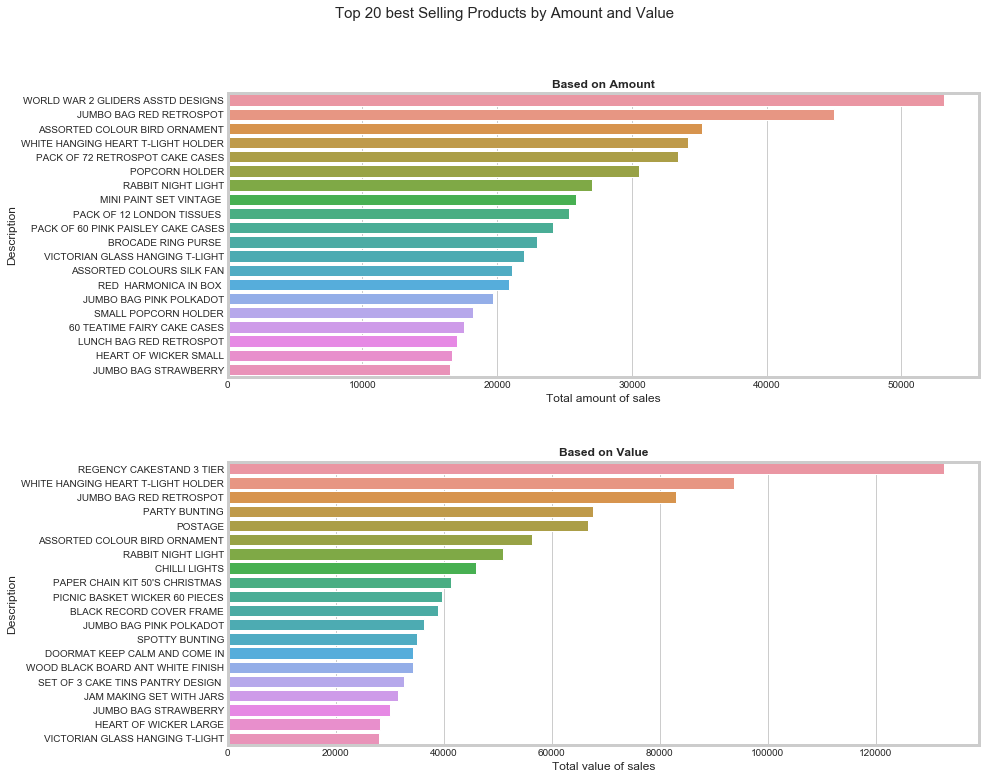

In [16]:
sns.set_style('whitegrid')
Quan = df.groupby('Description')['Quantity'].agg('sum').sort_values(ascending=False)[0:20]
Price = df.groupby('Description')['FinalPrice'].agg('sum').sort_values(ascending=False)[0:20]
#creating the subplot
fig,axs = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
plt.subplots_adjust(hspace = 0.3)
fig.suptitle('Top 20 best Selling Products by Amount and Value', fontsize=15, x = 0.4, y = 0.98)
sns.barplot(x=Quan.values, y=Quan.index, ax= axs[0]).set(xlabel='Total amount of sales')
axs[0].set_title('Based on Amount', size=12, fontweight = 'bold')
sns.barplot(x=Price.values, y=Price.index, ax= axs[1]).set(xlabel='Total value of sales')
axs[1].set_title('Based on Value', size=12, fontweight = 'bold')
plt.show()


Plot of Quanity Vs Price

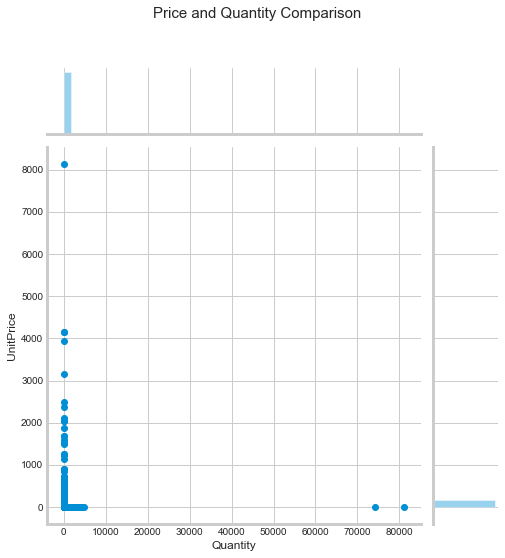

In [17]:
Corr = sns.jointplot(x="Quantity", y="UnitPrice", data = df[df.FinalPrice>0], height = 7)
Corr.fig.suptitle("Price and Quantity Comparison", fontsize = 15, y = 1.1)
plt.show()

Plots of Top returned items and Customers who did most Returns

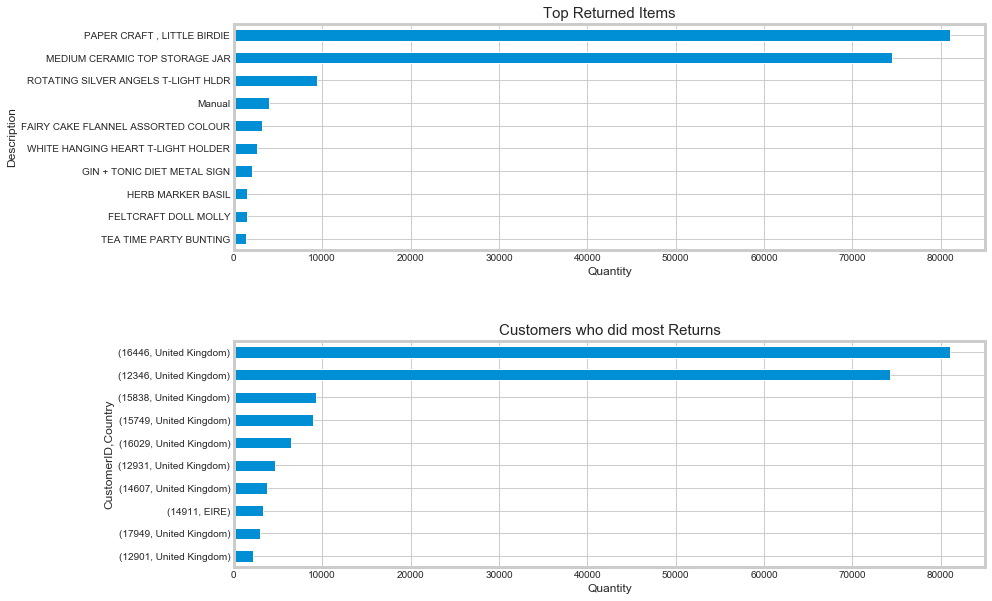

In [18]:
ReturnedItems = df[df.Quantity<0].groupby('Description')['Quantity'].sum()
ReturnedItems = ReturnedItems.abs().sort_values(ascending=False)[0:10]
ReturnCust = df[df.Quantity<0].groupby(['CustomerID','Country'])['Quantity'].sum()
ReturnCust = ReturnCust.abs().sort_values(ascending=False)[0:10]
#creting the subplot
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
ReturnedItems.sort_values().plot(kind='barh', ax=ax1).set_title('Top Returned Items', fontsize=15)
ReturnCust.sort_values().plot(kind='barh', ax=ax2).set_title('Customers who did most Returns', fontsize=15)
ax1.set(xlabel='Quantity')
ax2.set(xlabel='Quantity')
plt.subplots_adjust(hspace=0.4)
plt.show()

Plots showing sales and returns grouped by countrys

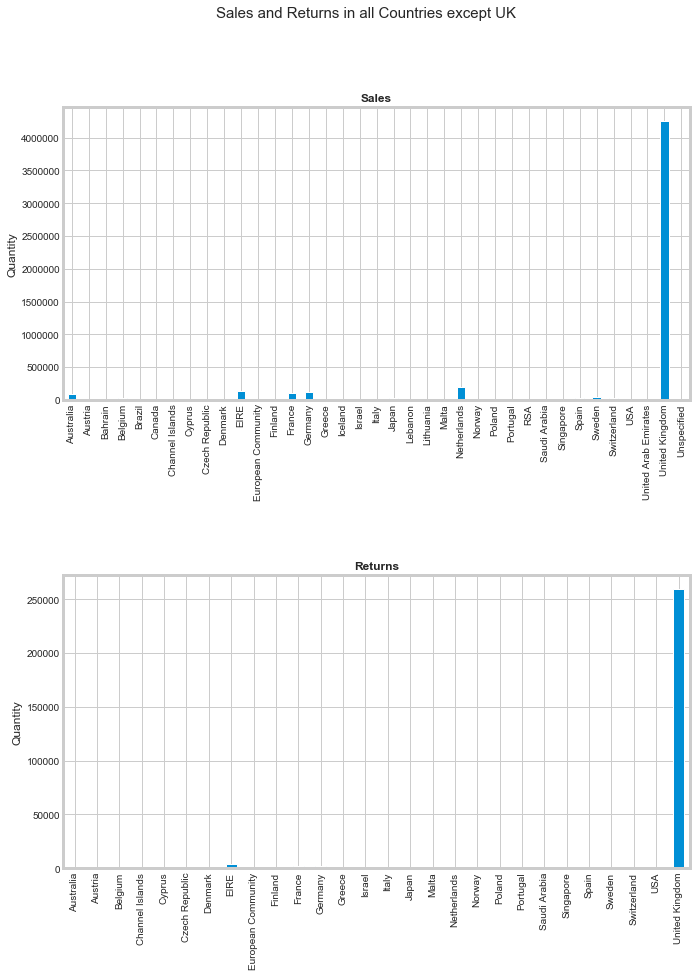

In [19]:
ByCountrySale = df[(df.Country != 'UNITED KINGDOM') & (df.Quantity > 0)].groupby('Country')['Quantity'].sum()
ByCountryRet = df[(df.Country != 'UNITED KINGDOM') & (df.Quantity < 0)].groupby('Country')['Quantity'].sum().abs()
fig, [ax1,ax2] = plt.subplots(nrows=2,ncols=1,figsize=(10,14))
ByCountrySale.plot(kind='bar', ax=ax1).set(ylabel = 'Quantity',xlabel='')
ax1.set_title('Sales', size=12, fontweight = 'bold')
ByCountryRet.plot(kind='bar', ax=ax2).set(ylabel = 'Quantity',xlabel='')
ax2.set_title('Returns', size=12, fontweight = 'bold')
plt.suptitle('Sales and Returns in all Countries except UK', fontsize = 15)
plt.subplots_adjust(hspace = 0.6)
plt.show()


Pie chart showing Sales value grouped by day

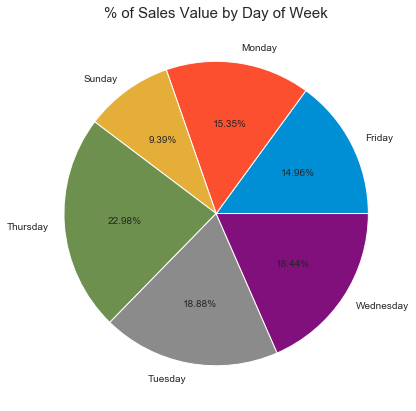

In [20]:
df.groupby('Day of week')['FinalPrice'].sum().plot(kind = 'pie', autopct = '%.2f%%', figsize=(7,7)).set(ylabel='')
plt.title('% of Sales Value by Day of Week', fontsize = 15)
plt.show()


Plots showing the top repeated customers

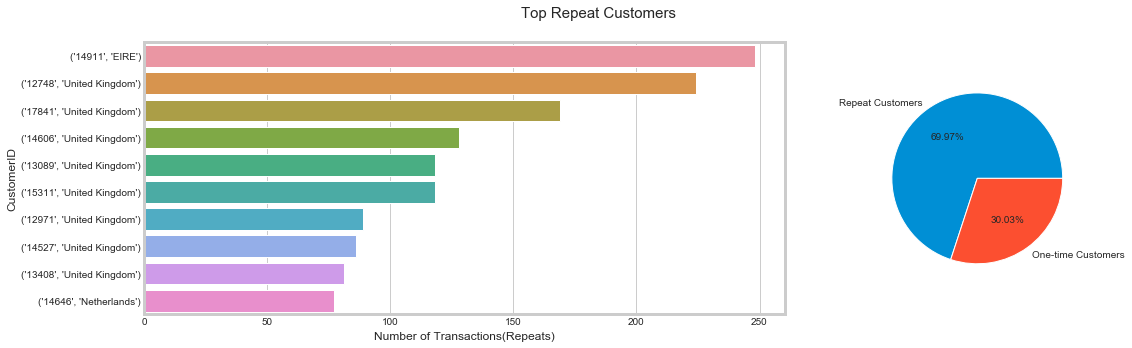

In [21]:
MostRepeat = df.groupby(['CustomerID','Country'])['InvoiceNo'].nunique().sort_values(ascending=False)
rep = MostRepeat[MostRepeat != 1].values
nrep = MostRepeat[MostRepeat == 1].values
ser = pd.Series([len(rep)/(len(rep)+len(nrep)),len(nrep)/(len(rep)+len(nrep))], index=['Repeat Customers','One-time Customers'])
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize= (15,5), gridspec_kw= {'width_ratios':[3,1]})
plt.subplots_adjust(wspace=0.2)
sns.barplot(x=MostRepeat[0:10].values, y=MostRepeat[0:10].index, ax=ax1).set(xlabel='Number of Transactions(Repeats)',ylabel='CustomerID')
ser.plot(kind='pie', autopct='%.2f%%', ax=ax2).set(ylabel='')
plt.suptitle('Top Repeat Customers', fontsize=15)
plt.show()

Plot showing the Sales value grouped by Month and Day

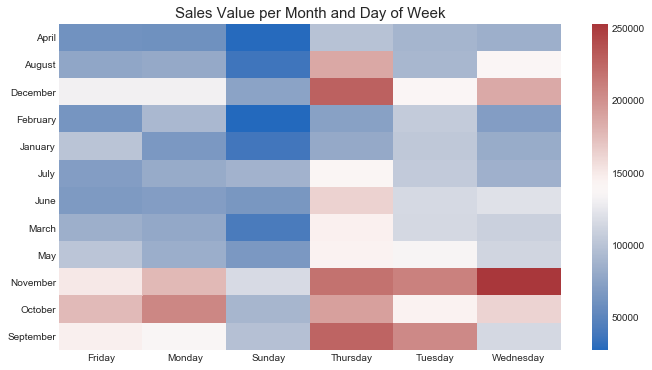

In [22]:
HM_Data = df.pivot_table(index = 'InvoiceMonth',columns = 'Day of week', values = 'FinalPrice', aggfunc='sum')
plt.figure(figsize = (10,6))
sns.heatmap(HM_Data, cmap = 'vlag').set(xlabel='', ylabel='')
plt.title('Sales Value per Month and Day of Week', fontsize = 15)
plt.show()

choropleth map showing Sales in each country

In [23]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio as py
import cufflinks as cf
import pycountry
import pycountry_convert
from pycountry_convert import country_name_to_country_alpha3
init_notebook_mode(connected=True)
%matplotlib inline

def code(x):
    try:
        return country_name_to_country_alpha3(x,cn_name_format='upper')
    except:
        pass
df['CountryCode'] = df['Country'].map(code)

#creating the choropleth map
mapdata = df.dropna()
map_data = {
    'type': 'choropleth',
    'autocolorscale' : False,
    'colorscale' : 'Portland',
    'locations' : mapdata[mapdata['CountryCode']!='GBR'].groupby('CountryCode', sort=False)['FinalPrice'].sum().index,
    'z' : mapdata[mapdata['CountryCode']!='GBR'].groupby('CountryCode', sort=False)['FinalPrice'].sum().values,
    'text' :  mapdata[mapdata['CountryCode']!='GBR']['Country'].unique(),
    'colorbar' : {'title':'Pounds'}
}
map_layout = {
    'title' : 'Sales in Foreign Countries',
    'geo' : {'showframe' : False, 'projection' : {'type':'equirectangular'}}
}
FinalMap = go.Figure(data = [map_data], layout = map_layout)
iplot(FinalMap)

Exploring Customers and Products and number of transactions made

In [24]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),'transactions': len(df['InvoiceNo'].value_counts()),
'customers': len(df['CustomerID'].value_counts()),}], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


Exploring the transactions grouped by CustomerId

In [25]:
exp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
no_products = exp.rename(columns = {'InvoiceDate':'Number of products'})
no_products[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


Analysis on cancelled orders

In [26]:
no_products['order_cancelled'] = no_products['InvoiceNo'].apply(lambda x:int('C' in x))
display(no_products[:5])
a = no_products['order_cancelled'].sum()
b = no_products.shape[0]
percentage = (a/b)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(a, b, percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders cancelled: 3654/22190 (16.47%) 


In [27]:
display(df.sort_values('CustomerID')[:10])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week,CountryCode
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,January,Tuesday,GBR
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6,January,Tuesday,GBR
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland,17.0,August,Tuesday,ISL
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland,13.2,January,Wednesday,ISL
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0,December,Tuesday,ISL
14944,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0,December,Tuesday,ISL
14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0,December,Tuesday,ISL
14946,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0,December,Tuesday,ISL
14947,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,15.0,December,Tuesday,ISL
148285,549222,22376,AIRLINE BAG VINTAGE JET SET WHITE,4,2011-04-07 10:43:00,4.25,12347,Iceland,17.0,April,Thursday,ISL


We observe that when a transaction is cancelled, there is another transaction which is made identical

In [28]:
df_cancel = df[df['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_cancel.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(df_cancel.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of a 'Discount' entry. so re running discrading the discount entry

In [29]:
df_cancel = df[(df['Quantity'] < 0) & (df['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_cancel.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(index, df_cancel.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Hypothesis is not verified again .

Below we are checking two scenarios:
1)If a cancel order exists without counterpart
2)If there's at least one counterpart with the exact same quantity

In [30]:
df_copy = df.copy(deep = True)
df_copy['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_copy.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_copy.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In [31]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [32]:
df_copy.drop(entry_to_remove, axis = 0, inplace = True)
df_copy.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_copy[(df_copy['Quantity'] < 0) & (df_copy['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week,CountryCode,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,-61.10,January,Monday,GBR,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,-19.80,February,Tuesday,GBR,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,-8.25,March,Monday,GBR,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,-24.50,March,Thursday,GBR,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,-32.34,March,Thursday,GBR,0


In [33]:
df_copy[(df_copy['CustomerID'] == 14048) & (df_copy['StockCode'] == '22464')]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week,CountryCode,QuantityCanceled


In [34]:
list_special_codes = df_copy[df_copy['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [35]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_copy[df_copy['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


Analysis of Basket Price

In [36]:
df_copy['TotalPrice'] = df_copy['UnitPrice'] * (df_copy['Quantity'] - df_copy['QuantityCanceled'])
df_copy.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week,CountryCode,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,January,Tuesday,GBR,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,17.0,April,Thursday,ISL,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,35.4,October,Monday,ISL,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,12.5,October,Monday,ISL,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,35.7,October,Monday,ISL,0,35.7


Purchase amount for every single order

In [37]:
order = df_copy.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
price_of_basket = order.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_copy['InvoiceDate_int'] = df_copy['InvoiceDate'].astype('int64')
order = df_copy.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_copy.drop('InvoiceDate_int', axis = 1, inplace = True)
price_of_basket.loc[:, 'InvoiceDate'] = pd.to_datetime(order['InvoiceDate_int'])

# selection of significant entries
price_of_basket = price_of_basket[price_of_basket['Basket Price'] > 0]
price_of_basket.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


Distribution of orders and their total amount of purchases

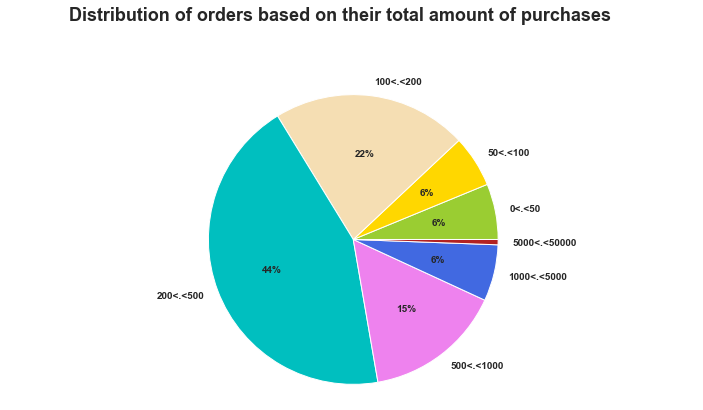

In [38]:
price_list = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_list):
    if i == 0: continue
    val = price_of_basket[(price_of_basket['Basket Price'] < price) &
                       (price_of_basket['Basket Price'] > price_list[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_list[i-1], s) for i,s in enumerate(price_list) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of orders based on their total amount of purchases", ha='center', fontsize = 18);

Analysis of the product categories

In [39]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [40]:
df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})


In [41]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)


number of keywords in variable 'Description': 1484


In [42]:
products = []
for k,v in count_keywords.items():
    products.append([keywords_select[k],v])
products.sort(key = lambda x:x[1], reverse = True)

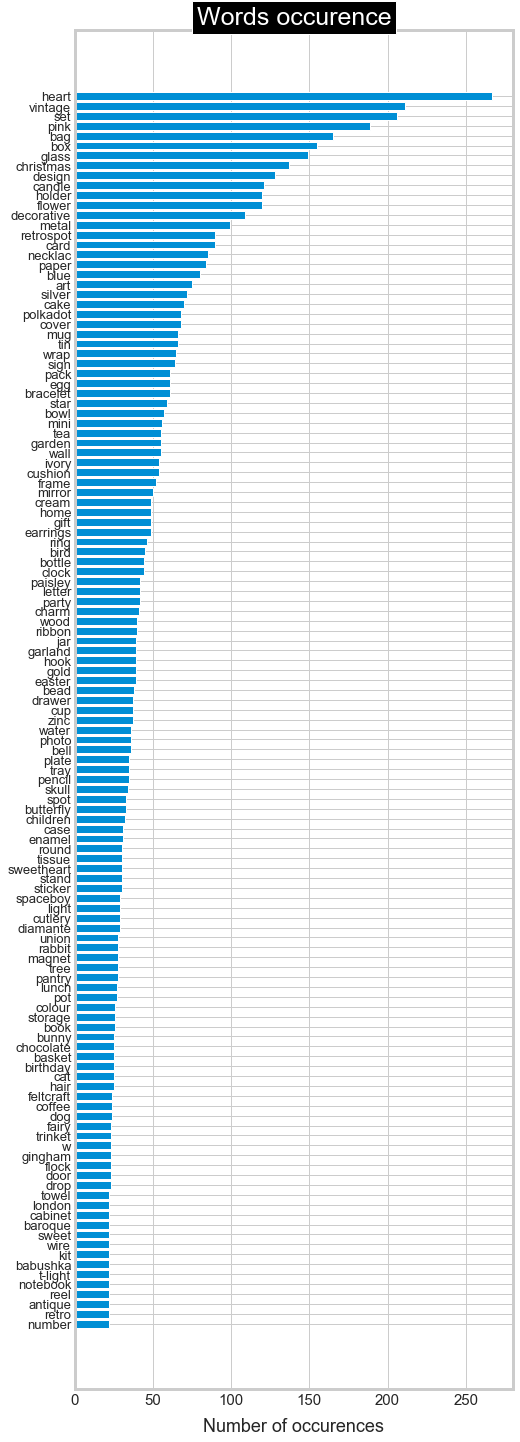

In [43]:
liste = sorted(products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()


Forming product categories by keywords

In [44]:
products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    products.append([word, v])
 
products.sort(key = lambda x:x[1], reverse = True)
print('Preserved words:', len(products))

Preserved words: 193


In [45]:
liste_produits = df_copy['Description'].unique()
#print(liste_produits[0:2])
X = pd.DataFrame()
for key, occurence in products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))


In [46]:
level = [0, 1, 2, 3, 5, 10]
label = []
for i in range(len(level)):
    if i == len(level)-1:
        col = '.>{}'.format(level[i])
    else:
        col = '{}<.<{}'.format(level[i],level[i+1])
    #print(i)
    #print(col)
    label.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_copy[ df_copy['Description'] == prod]['UnitPrice'].mean()
    #print (prix)
    j = 0
    while prix > level[j]:
        j+=1
        if j == len(level): break
    X.loc[i, label[j-1]] = 1

In [47]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(level)):
    if i == len(level)-1:
        col = '.>{}'.format(level[i])
    else:
        col = '{}<.<{}'.format(level[i],level[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


Creating clusters of products


In [48]:
range_clus = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(range_clus)
    clusters = kmeans.predict(range_clus)
    silhouette_avg = silhouette_score(range_clus, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.09371101751039933
For n_clusters = 4 The average silhouette_score is : 0.12463928525280715
For n_clusters = 5 The average silhouette_score is : 0.14631355248870398
For n_clusters = 6 The average silhouette_score is : 0.14524437780972266
For n_clusters = 7 The average silhouette_score is : 0.15961172545889715
For n_clusters = 8 The average silhouette_score is : 0.13432847236031564
For n_clusters = 9 The average silhouette_score is : 0.14699626565052548


In [49]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(range_clus)
    clusters = kmeans.predict(range_clus)
    silhouette_avg = silhouette_score(range_clus, clusters)
    print("For n_clusters =", n_clusters, "The avg silhouette_score:", silhouette_avg)

For n_clusters = 5 The avg silhouette_score: 0.1466257603527048


Representation of the content of clusters

In [50]:
pd.Series(clusters).value_counts()

2    1009
3     964
1     762
0     673
4     470
dtype: int64

a: Silhouette intra-cluster score

In [51]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
        y_lower = y_upper + 10

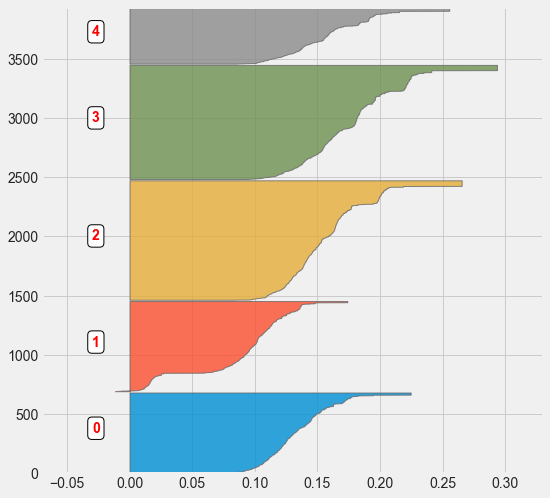

In [52]:
sample_silhouette_values = silhouette_samples(range_clus, clusters)

graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

b.Word Cloud

In [53]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

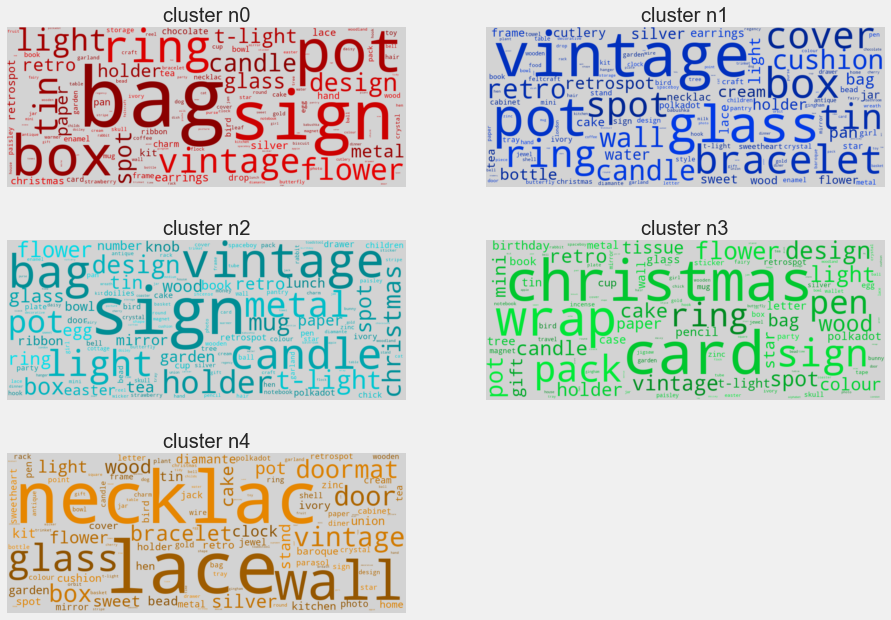

In [54]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)


c: Principal Component Analysis

In [55]:
pca = PCA()
pca.fit(range_clus)
pca_samples = pca.transform(range_clus)

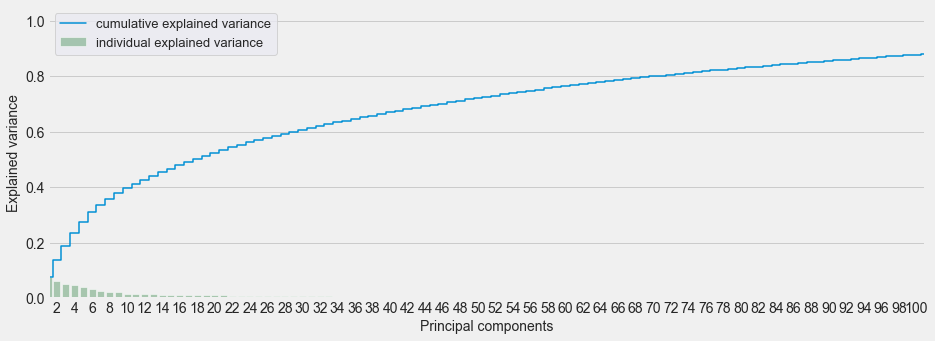

In [56]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(range_clus.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,range_clus.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [57]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(range_clus)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

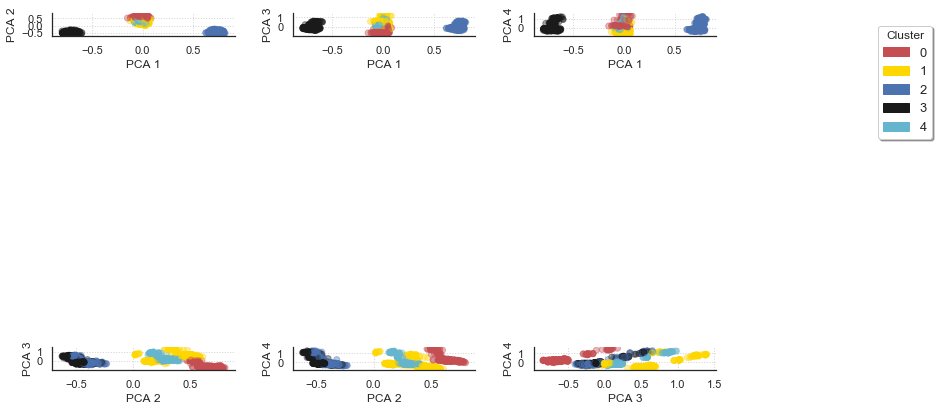

In [58]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        

comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,fontsize = 13, 
           bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

Categorizing products

In [59]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_copy['categ_product'] = df_copy.loc[:, 'Description'].map(corresp)
df_copy[['InvoiceNo', 'Description', 
            'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0
1,536365,WHITE METAL LANTERN,1
2,536365,CREAM CUPID HEARTS COAT HANGER,1
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1
5,536365,SET 7 BABUSHKA NESTING BOXES,4
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1
7,536366,HAND WARMER UNION JACK,0
8,536366,HAND WARMER RED POLKA DOT,2
9,536367,ASSORTED COLOUR BIRD ORNAMENT,2


Creating CategN which contains the total amount spent in each category

In [60]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_copy[df_copy['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_copy.loc[:, col] = price_temp
    df_copy[col].fillna(0, inplace = True)


df_copy[['InvoiceNo', 'Description', 
            'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.00,0.00,0.0,0.0
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.00,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.00,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.00,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.00,0.0,0.0
5,536365,SET 7 BABUSHKA NESTING BOXES,4,0.0,0.00,0.00,0.0,15.3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1,0.0,25.50,0.00,0.0,0.0
7,536366,HAND WARMER UNION JACK,0,11.1,0.00,0.00,0.0,0.0
8,536366,HAND WARMER RED POLKA DOT,2,0.0,0.00,11.10,0.0,0.0
9,536367,ASSORTED COLOUR BIRD ORNAMENT,2,0.0,0.00,54.08,0.0,0.0


Created a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [61]:
temp = df_copy.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
price_of_basket = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_copy.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    price_of_basket.loc[:, col] = temp 


df_copy['InvoiceDate_int'] = df_copy['InvoiceDate'].astype('int64')
temp = df_copy.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_copy.drop('InvoiceDate_int', axis = 1, inplace = True)
price_of_basket.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

price_of_basket = price_of_basket[price_of_basket['Basket Price'] > 0]
price_of_basket.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,83.40,293.35,187.2,23.40,124.44,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,53.10,207.45,130.5,84.34,0.00,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,71.10,153.25,330.9,81.00,0.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,78.06,168.76,74.4,41.40,19.90,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,119.70,196.41,109.7,61.30,97.80,2011-08-02 08:48:00.000000000


In [62]:
print(price_of_basket['InvoiceDate'].min(), '->',  price_of_basket['InvoiceDate'].max())


2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [63]:
set_entrainement = price_of_basket[price_of_basket['InvoiceDate'] < pd.Timestamp(datetime.date(2011,10,1))]
set_test         = price_of_basket[price_of_basket['InvoiceDate'] >= pd.Timestamp(datetime.date(2011,10,1))]
price_of_basket = set_entrainement.copy(deep = True)

In [64]:
set_test

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
6,12347,573511,1294.32,435.90,445.22,203.30,154.30,55.60,2011-10-31 12:25:00.000001280
7,12347,581180,224.82,55.44,0.00,100.80,38.58,30.00,2011-12-07 15:52:00.000000000
12,12349,577609,1757.55,215.22,638.80,465.86,79.32,358.35,2011-11-21 09:51:00.000000256
21,12352,574275,311.73,27.23,102.50,107.30,20.80,53.90,2011-11-03 14:36:59.999999744
27,12356,576895,58.35,0.00,58.35,0.00,0.00,0.00,2011-11-17 08:40:00.000000000
...,...,...,...,...,...,...,...,...,...
18626,18283,578262,307.05,152.89,0.00,86.12,68.04,0.00,2011-11-23 13:27:00.000002048
18627,18283,579673,220.31,106.21,9.75,74.70,29.65,0.00,2011-11-30 12:58:59.999998720
18628,18283,580872,208.00,119.03,0.00,61.90,27.07,0.00,2011-12-06 12:02:00.000001792
18630,18287,570715,1001.32,326.04,32.00,386.44,256.84,0.00,2011-10-12 10:22:59.999998720


Consumer order combinations

In [65]:
# of visits and stats on cart amount / users
transactions_per_user=price_of_basket.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min',
                                                                                   'max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = price_of_basket.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
price_of_basket.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,36.519926,29.836681,10.442659,8.676179
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,41.953217,38.016069,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.961722,48.444976,11.692584,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,68.944734,12.892120,0.491808,14.301006
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,44.719101,13.033708,0.000000,22.359551


Defining two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [66]:
last_date = price_of_basket['InvoiceDate'].max().date()

first_registration = pd.DataFrame(price_of_basket.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(price_of_basket.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,36.519926,29.836681,10.442659,8.676179,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,41.953217,38.016069,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.961722,48.444976,11.692584,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,68.944734,12.892120,0.491808,14.301006,2,226
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,44.719101,13.033708,0.000000,22.359551,134,134


In [67]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1445/3608  (40.05%)


#### Creating customer categories

In [68]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
selected_customers = transactions_per_user.copy(deep = True)
range_clus = selected_customers[list_cols].values

In [69]:
scaler = StandardScaler()
scaler.fit(range_clus)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(range_clus)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  21.19884856
  23.91238925  25.22916919  13.98907929  15.67936332]


define a base of smaller dimension allowing to describe the scaled_matrix matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [70]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

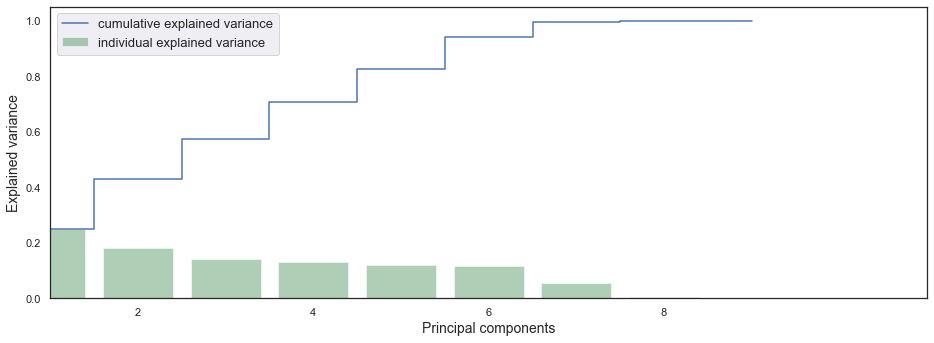

In [71]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(range_clus.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,range_clus.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

Creating customer categories

In [72]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.213


checking to see number of customer per each cluster

In [73]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,2,8,7,0,1,4,9,6,3,10,5
number of clients,1464,457,443,350,295,231,187,153,13,8,7


In [74]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

a. Visualize the clusters using PCA

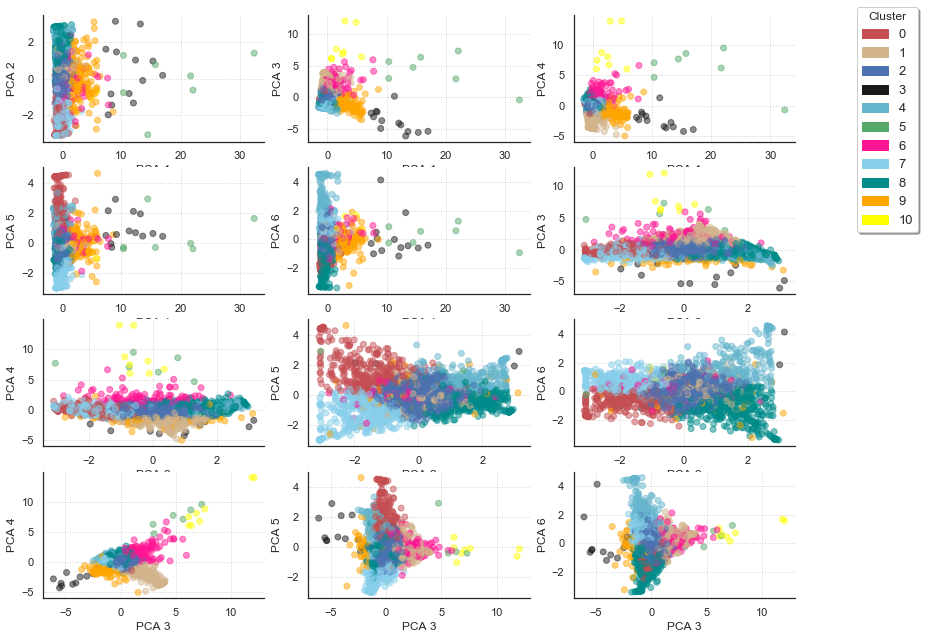

In [75]:

import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

Score of the silhouette intra-cluster

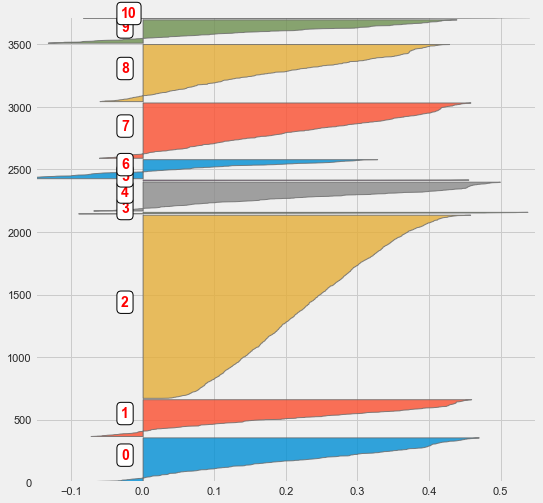

In [76]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, 
                           clusters_clients)

Radar charts

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [77]:
selected_customers.loc[:,'cluster'] = clusters_clients

In [78]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


Re ordering the df by ordering different types of clusters in relation with total amount spent and product category

In [79]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,1.0,2.586441,212.492847,382.455051,293.622324,822.563898,60.795005,9.699705,15.170461,6.994460,7.340370,295
1,7.0,2.252822,210.994628,362.179233,275.874307,708.503521,11.831156,59.182940,10.875905,5.226922,12.905172,443
2,8.0,2.424508,215.667681,329.200155,269.528404,664.637880,12.708949,11.097646,57.355355,12.894157,5.947151,457
3,4.0,2.199134,193.774026,317.699913,247.165261,582.228312,11.101421,7.841102,18.052858,57.570041,5.434577,231
4,0.0,2.502857,192.872803,312.765600,246.358670,637.946117,11.562019,19.315748,11.688894,5.298483,52.150979,350
5,2.0,3.279372,216.870315,456.073382,327.600802,1084.333607,22.194516,23.523794,25.992570,13.992618,14.304444,1464
6,9.0,1.759358,1036.156791,1429.955888,1215.880374,2298.225406,21.273210,26.342051,26.345217,12.099292,13.940591,187
7,3.0,1.692308,3253.388462,4380.010000,3794.797051,6250.506154,13.782335,25.680144,19.704883,21.744522,19.088117,13
8,6.0,18.183007,88.616536,1610.024314,565.635269,9826.114314,25.251943,23.000190,23.826983,12.225835,15.715529,153
9,10.0,87.125000,20.862500,2643.812500,456.526689,37313.235000,24.604929,22.340235,25.165035,11.477885,16.434535,8


Customers graphical representation

In [80]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

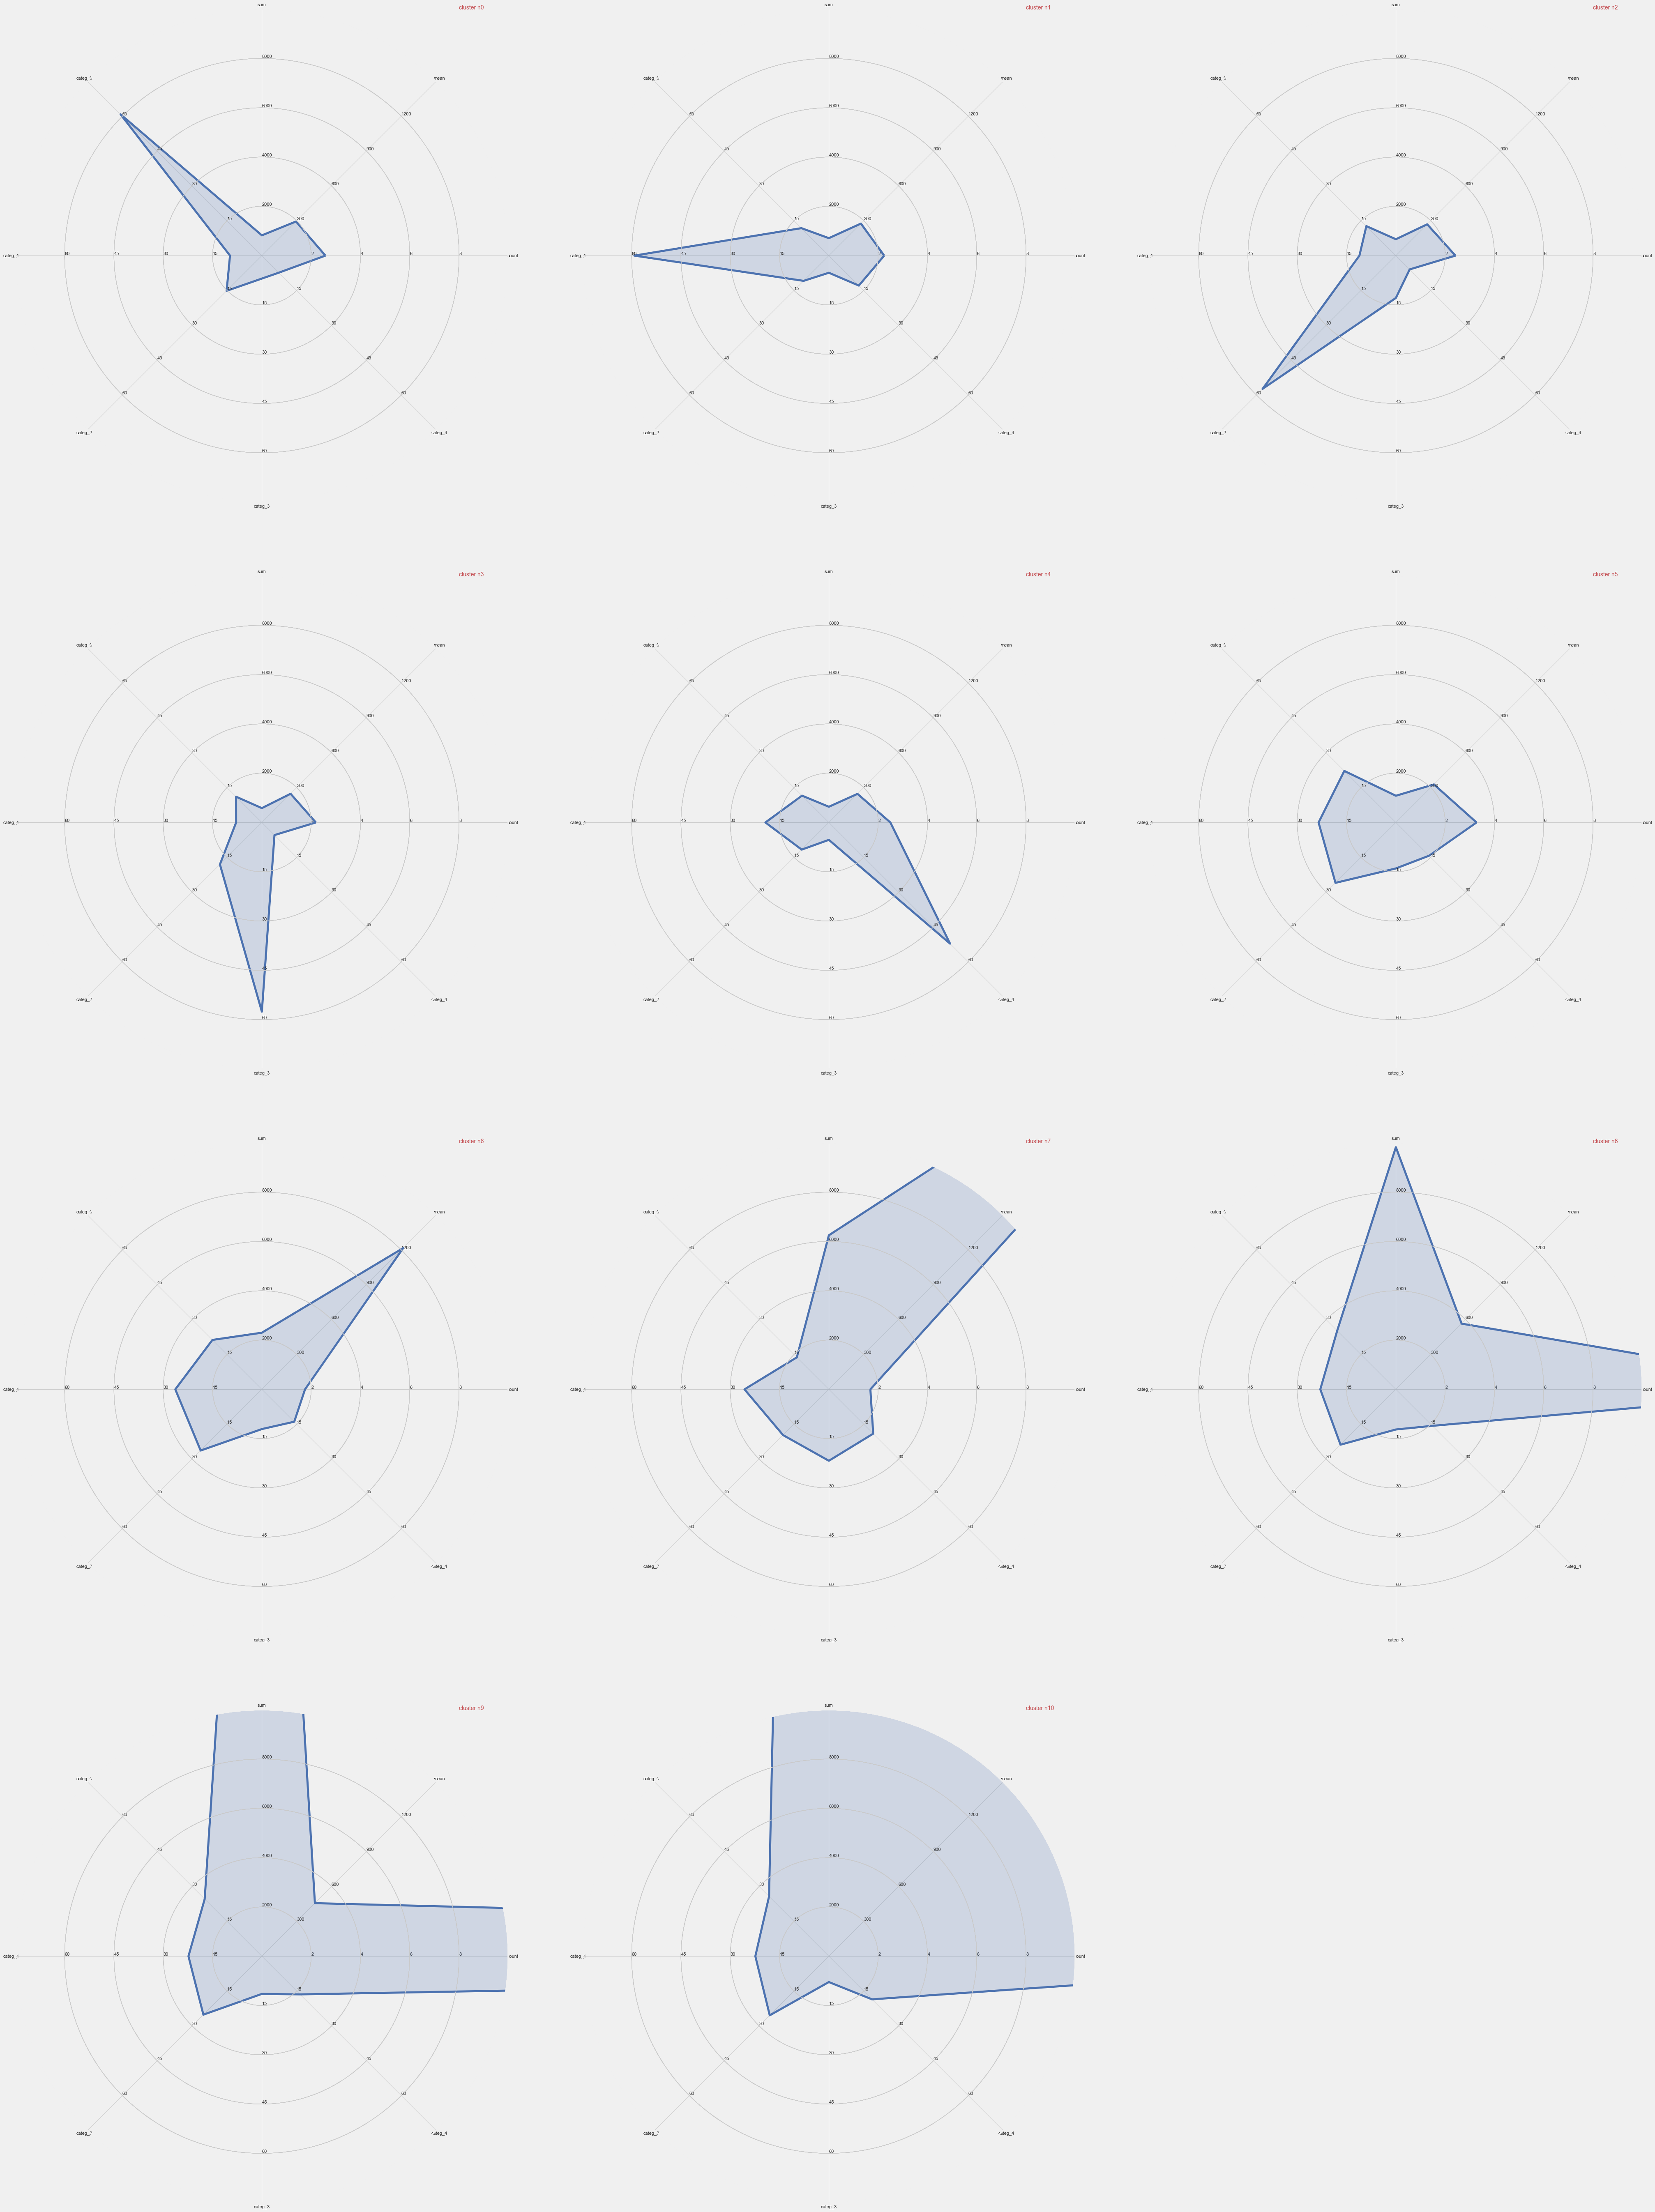

In [82]:
fig = plt.figure(figsize=(50,50))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(merged_df.loc[index[ind], attributes])  
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=5.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n{}'.format(index[ind]), color = 'r')
    ind += 1

Classification of customers : In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section

In [83]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [84]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,36.519926,29.836681,10.442659,8.676179,59,297,2
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,41.953217,38.016069,0.000000,5,288,8
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.961722,48.444976,11.692584,0.000000,240,240,8
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,68.944734,12.892120,0.491808,14.301006,2,226,7
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,44.719101,13.033708,0.000000,22.359551,134,134,7


In [85]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [86]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)


SVC

In [87]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 10)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)


Precision: 80.75 % 


Confusion matrix

In [88]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


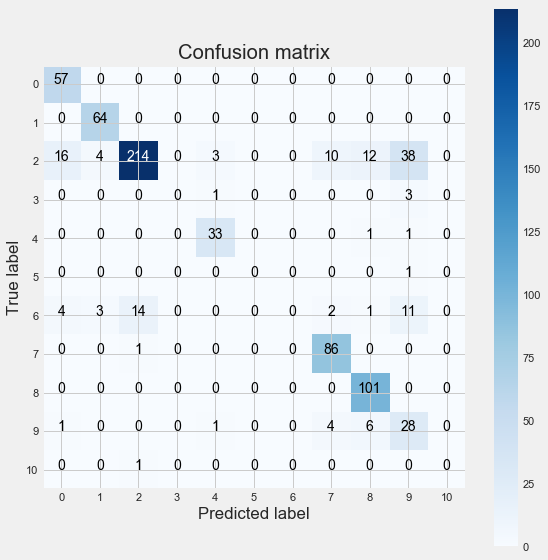

In [89]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

SVC learning curve

In [90]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

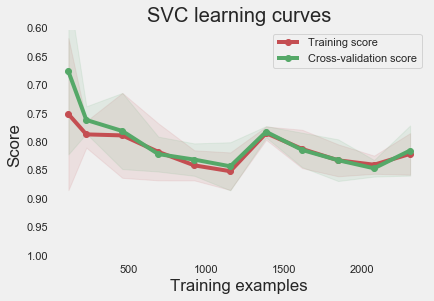

In [91]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

Logistic Regression

In [92]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 89.47 % 


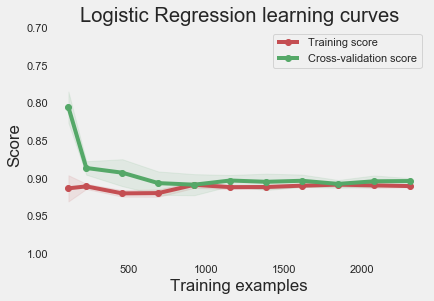

In [93]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

KNN

In [94]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 78.25 % 


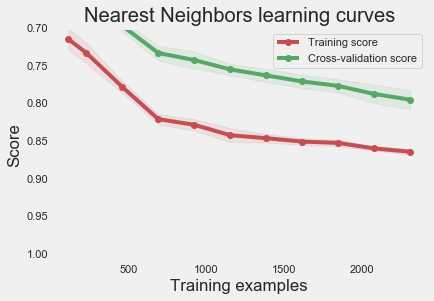

In [95]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Decison Tree

In [96]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 83.80 % 


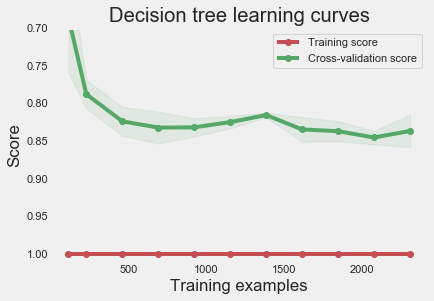

In [97]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Random Forest

In [98]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 89.61 % 


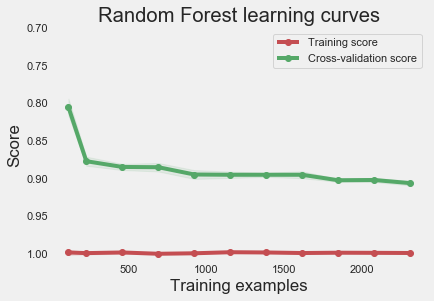

In [99]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Ada Boost Classifier

In [100]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 54.16 % 


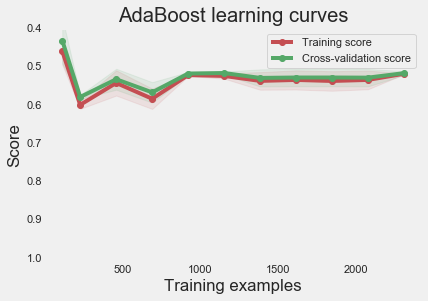

In [101]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Gradient Boosting Classifier

In [102]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 88.64 % 


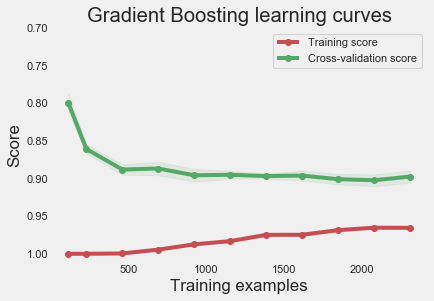

In [103]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Conclusion

In [104]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [105]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

In [106]:
votingC = votingC.fit(X_train, Y_train)


In [107]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 89.61 % 


Testing Predictions

In [108]:
price_of_basket = set_test.copy(deep = True)


In [109]:
transactions_per_user=price_of_basket.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = price_of_basket.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
price_of_basket.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]



,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,32.343299,29.307371,20.017905,12.696657,5.634767
1,12349,5,1757.55,1757.55,1757.55,8787.75,12.245455,36.346050,26.506216,4.513101,20.389178
2,12352,5,311.73,311.73,311.73,1558.65,8.735123,32.881019,34.420813,6.672441,17.290604
3,12356,5,58.35,58.35,58.35,291.75,0.000000,100.000000,0.000000,0.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,14.684737,36.560900,18.475531,5.089832,25.189000


In [110]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

In [111]:
Y = kmeans.predict(scaled_test_matrix)

columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [112]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logistic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 68.56 % 
______________________________ 
Logistic Regression
Precision: 75.19 % 
______________________________ 
k-Nearest Neighbors
Precision: 67.19 % 
______________________________ 
Decision Tree
Precision: 69.23 % 
______________________________ 
Random Forest
Precision: 75.03 % 
______________________________ 
Gradient Boosting
Precision: 75.34 % 


In [113]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 75.97 % 
